In [1]:
!sudo apt-get update
!sudo apt-get -y install enchant-2
!pip install ftfy regex tqdm pyenchant
!pip install git+https://github.com/openai/CLIP.git
import clip
import json
import numpy as np
import torch
import torchtext
from PIL import Image
from IPython.display import Image as IM
from IPython.display import display
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import enchant
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
ms_1 = ['ViT-L/14', 'RN50x64']
ms = ['ViT-L14', 'RN50x64']
m = ms[1].replace('/','')
model, preprocess = clip.load(ms[1], device=device)

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:3 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:6 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [467 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]    
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]        
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [361 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]     
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [634 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Pack

100%|█████████████████████████████████████| 1.26G/1.26G [00:18<00:00, 72.1MiB/s]


In [ ]:
display(IM(filename='/kaggle/input/vizwiz/data/Images/VizWiz_train_000000000001.jpg'))

In [2]:
data = None

with open('/kaggle/input/vizwiz/data/Annotations/train.json') as f:
  data = json.load(f)

In [3]:
with open('/kaggle/input/vizwiz/data/Annotations/val.json') as f:
  val_data = json.load(f)

In [4]:
answer_freq = {}
for entry in data:
    for ans in entry['answers']:
        if ans['answer'] in answer_freq.keys():
            answer_freq[ans['answer']]+=1
        else:
            answer_freq[ans['answer']] = 1

In [5]:
len(answer_freq.keys())

40271

In [6]:
def get_answers_from_dict(answers_dict):
    answers = [entry['answer'] for entry in answers_dict]
    return answers

In [7]:
def get_answer_clip(model, preprocess, img_path, answers):
    global device
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    text = clip.tokenize(answers).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    return np.argmax(probs)

In [8]:
def get_lowest_levenshtein(answers, candidates):
    scores = []
    for candidate in candidates:
        score = 0
        for answer in answers:
            score+=enchant.utils.levenshtein(candidate, answer)
        scores.append(score)
        
    return np.argmin(scores)

In [9]:
def get_most_common(answers, all_answers):
    global answer_frq
    idx = None
    freq = -1
    draws = []
    for i, answer in enumerate(answers):
        if answer in answer_freq.keys():
            fq = answer_freq[answer]
        else:
            fq = 0
        if fq>freq:
            idx = i
            freq = fq
            draws = [(answer,i)]
        elif fq==freq:
            draws.append((answer,i))
            
    if len(draws)>1:
        candids = [a[0] for a in draws]
        idx = draws[get_lowest_levenshtein(all_answers, candids)][1]
    return idx

In [10]:
def get_answer_most_common(answers, model=None, preprocess=None, img_path=None, clip=False, freq=False):
    common_idx = None
    count = -1
    draws = []
    for idx,answer in enumerate(answers):
        c = answers.count(answer)
        if c > count:
            count = c
            common_idx = idx
            draws = [(answer, idx)]
        elif c==count:
            draws.append((answer, idx))
            
    if len(draws)>1:
        tmp = [a[0] for a in draws]
        if clip:
            common_idx = draws[get_answer_clip(model, preprocess, img_path, tmp)][1]
        elif freq:
            common_idx = draws[get_most_common(tmp, answers)][1]
#         common_idx = draws[get_lowest_levenshtein(answers, tmp)][1]
    return common_idx

In [11]:
def create_df(data, selection=2):
    df = []

    for i,entry in enumerate(data):
        if selection==5:
            answers = get_answers_from_dict(entry['answers'])
            df.append([entry['image'], entry['answerable'], entry['question'], entry['answer_type'], answers])
        else:
            if entry['answerable']==0:
                answer = 'unanswerable'
            else:
                if selection==1:
                    idx = get_answer_clip(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+entry['image'], get_answers_from_dict(entry['answers']))
                elif selection==2:
                    idx = get_answer_most_common(get_answers_from_dict(entry['answers']))
                elif selection==3:
                    idx = get_answer_most_common(get_answers_from_dict(entry['answers']), model=model, preprocess=preprocess, img_path='/kaggle/input/vizwiz/data/Images/'+entry['image'], clip=True)
                elif selection==4:
                    idx = get_answer_most_common(get_answers_from_dict(entry['answers']), freq=True)    

                answer = entry['answers'][idx]['answer']

            df.append([entry['image'], entry['answerable'], entry['question'], entry['answer_type'], answer])
        if i%1000==0:
            print('Checkpoint at: ' + str(i))
    if selection==5:
        return df
    return np.array(df)

In [13]:
selection=4

In [12]:
df = create_df(data, selection)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000
Checkpoint at: 4000
Checkpoint at: 5000
Checkpoint at: 6000
Checkpoint at: 7000
Checkpoint at: 8000
Checkpoint at: 9000
Checkpoint at: 10000
Checkpoint at: 11000
Checkpoint at: 12000
Checkpoint at: 13000
Checkpoint at: 14000
Checkpoint at: 15000
Checkpoint at: 16000
Checkpoint at: 17000
Checkpoint at: 18000
Checkpoint at: 19000


In [13]:
with open('/kaggle/working/df'+str(selection)+'.npy', 'wb') as f:
    np.save(f,df)

In [14]:
with open('/kaggle/input/dfasdasd/df' + str(selection) + '.npy', 'rb') as f: 
    df = np.load(f)

In [15]:
df.shape

(20000, 5)

In [16]:
answers = np.array([entry[4] for entry in df])

In [17]:
answer_types = np.array([entry[3] for entry in df])

In [18]:
answerable = torch.Tensor([1 if entry[1]=='1' else 0 for entry in df])

In [42]:
selection = 5

In [43]:
val_df = create_df(val_data, selection)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000


In [19]:
with open('/kaggle/working/val_df'+str(selection)+'.npy', 'wb') as f:
    np.save(f,val_df)

In [19]:
with open('/kaggle/input/dfasdasd/val_df' + str(selection) + '.npy', 'rb') as f: 
    val_df = np.load(f)

In [20]:
val_answers = np.array([entry[4] for entry in val_df])

In [21]:
val_answer_types = np.array([entry[3] for entry in val_df])

In [22]:
val_answerable = torch.Tensor([1 if entry[1]=='1' else 0 for entry in val_df])

In [23]:
def create_samples(model, preprocess, img_path, question, rotate=True):
    global device
    samples = []
    img = Image.open(img_path)
    
    encoded_q = model.encode_text(clip.tokenize(question).to(device))
    encoded_img = model.encode_image(preprocess(img).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))
    if not rotate:
        return torch.hstack([encoded_img, encoded_q])

    # Rotate Image By 90 Degree
    rotated_image1 = img.rotate(90)
    encoded_img_r90 = model.encode_image(preprocess(rotated_image1).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))

    # Rotate Image By 180 Degree
    rotated_image2 = img.rotate(-90)
    encoded_img_rn90 = model.encode_image(preprocess(rotated_image2).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))

#     # Rotate Image By 270 Degree
#     rotated_image3 = img.rotate(270)
#     encoded_img3 = model.encode_image(preprocess(rotated_image3).unsqueeze(0).to(device))
#     samples.append(torch.hstack([encoded_img, encoded_q]))
        
    average = (encoded_img + encoded_img_r90 + encoded_img_rn90) / 3
    return torch.hstack([average, encoded_q])
        

In [24]:
def create_X(df, rotate=False):
    global device
    X = []

    with torch.no_grad():
      for i, entry in enumerate(df):
        X.extend(create_samples(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+entry[0], entry[2], rotate))
        if i%1000==0:
            print('Checkpoint at: ' + str(i))

    return torch.vstack(X)

In [66]:
X = create_X(df, rotate=True)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000
Checkpoint at: 4000
Checkpoint at: 5000
Checkpoint at: 6000
Checkpoint at: 7000
Checkpoint at: 8000
Checkpoint at: 9000
Checkpoint at: 10000
Checkpoint at: 11000
Checkpoint at: 12000
Checkpoint at: 13000
Checkpoint at: 14000
Checkpoint at: 15000
Checkpoint at: 16000
Checkpoint at: 17000
Checkpoint at: 18000
Checkpoint at: 19000


In [67]:
torch.save(X,'/kaggle/working/X_' + m + '.pt')

In [ ]:
X = torch.load('/kaggle/input/dfasdasd/X_' + m + '.pt', map_location=device)

In [25]:
X_1 = torch.load('/kaggle/input/dfasdasd/X_' + ms[0] + '.pt', map_location=device)
X_2 = torch.load('/kaggle/input/dfasdasd/X_' + ms[1] + '.pt', map_location=device)
# X = [(x1, x2) for x1, x2 in zip(X_1, X_2)]

In [68]:
X_val = create_X(val_df, rotate=True)

Checkpoint at: 0
Checkpoint at: 1000
Checkpoint at: 2000
Checkpoint at: 3000


In [69]:
torch.save(X_val,'/kaggle/working/X_val_' + m + '.pt')

In [28]:
X_val = torch.load('/kaggle/input/dfasdasd/X_val_' + m + '.pt', map_location=device)

In [26]:
X_val_1 = torch.load('/kaggle/input/dfasdasd/X_val_' + ms[0] + '.pt', map_location=device)
X_val_2 = torch.load('/kaggle/input/dfasdasd/X_val_' + ms[1] + '.pt', map_location=device)
# X_val = [(x1, x2) for x1, x2 in zip(X_val_1, X_val_2)]

In [27]:
lb_types = preprocessing.LabelBinarizer()

encoded_answer_types = lb_types.fit_transform(answer_types)

print(encoded_answer_types[10])

[0 1 0 0]


In [28]:
lb_types.classes_

array(['number', 'other', 'unanswerable', 'yes/no'], dtype='<U12')

In [29]:
lb_answers = preprocessing.LabelBinarizer()

encoded_answers = lb_answers.fit_transform(answers)

print(encoded_answers[10])

[0 0 0 ... 0 0 0]


In [30]:
lb_answers.classes_.shape

(4856,)

In [31]:
y = [(a_type, a) for a_type, a in zip(encoded_answer_types, encoded_answers)]

In [32]:
val_encoded_answer_types = lb_types.transform(val_answer_types)
# val_encoded_answers = [lb_answers.transform(a) for a in val_answers]
val_encoded_answers = lb_answers.transform(val_answers)
y_val = [(a_type, a) for a_type, a in zip(val_encoded_answer_types, val_encoded_answers)]

# This is a problem :)

In [35]:
c = 0
for ans in val_encoded_answers:
    c += ans.sum()
print(c)
print(len(val_encoded_answers))

2605
3173


In [41]:
c = 0
for ans in val_encoded_answer_types:
    c += ans.sum()
print(c)
print(len(val_encoded_answer_types))

3173
3173


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [33]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class VQADataset(Dataset):
    def __init__(self, data, labels, single=False, ensemble=False):
        self.ensemble = ensemble
        if ensemble:
            self.data1 = []
            self.data2 = []
            for d1, d2 in data:
                self.data1.append(d1)
                self.data2.append(d2)
        else:
            self.data = data
            
        self.single = single
        if single:
            self.labels = labels
        else:
            self.atypes = []
            self.answers = []
            for atype, ans in labels:
              self.atypes.append(atype)
              self.answers.append(ans)

    def __len__(self):
        if self.ensemble:
            return len(self.data1)
        return len(self.data)

    def __getitem__(self, index):
        returnable = []
        if self.ensemble:
            x1, x2 = torch.Tensor(self.data1[index]), torch.Tensor(self.data2[index])
            returnable.append(x1)
            returnable.append(x2)
        else:
            x = torch.Tensor(self.data[index])
            returnable.append(x)
        if self.single:
            y = self.labels[index]
            returnable.append(y)
        else:
            at, a = torch.Tensor(self.atypes[index]), torch.Tensor(self.answers[index])
            returnable.append(at)
            returnable.append(a)
        return tuple(returnable)

In [35]:
class VQA_Network(nn.Module):
    def __init__(self, num_classes, vocab_size, hidden_dim, embedding_dim):
        super(VQA_Network, self).__init__()

        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.fc2_answers = nn.Linear(hidden_dim, vocab_size)

        self.fc2_aux = nn.Linear(hidden_dim, num_classes)
        self.fc3_aux = nn.Linear(num_classes, vocab_size)

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.to(dtype=torch.float32)
        x = self.fc(x)
        x = self.norm(x)
        x = self.dropout(x)

        atype = self.fc2_aux(x)
        aux = self.fc3_aux(atype)

        answers = self.fc2_answers(x)

        answers = answers * self.sigmoid(aux)

        return answers, atype


In [36]:
def calculate_acc(batch_output, labels):
    acc = 0
    for output, answers in zip(batch_output, labels):
        c = 0
        for answer in answers:
            if (torch.argmax(output)==torch.argmax(torch.Tensor(answer))):
                c+=1
        acc+=min((c/3),1)
    return acc

In [43]:
train_set = DataLoader(VQADataset(X_2, y), batch_size=32)
# test_set = DataLoader(VQADataset(X_test, y_test), batch_size=512)
val_set = DataLoader(VQADataset(X_val_2, y_val), batch_size=32)

In [44]:
num_classes = 4
vocab_size = 4856
hidden_dim = 512
embedding_dim = 1024*2
train_accs_a = []
val_accs_a = []
train_accs_at = []
val_accs_at = []
highest_acc = -1

num_epochs = 70

# Instantiate the model
model = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss_a = 0.0
    running_loss_at = 0.0
    acc_a = 0
    acc_at = 0
    val_running_loss_a = 0.0
    val_running_loss_at = 0.0
    val_acc_a = 0
    val_acc_at = 0

    for xs, atypeset, answerset in train_set:
        # Move data to the device
        xs = xs.to(device)
        atypeset = atypeset.to(device)
        answerset = answerset.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        answers, atypes = model(xs)
        # print(xs.size())
        # print(labelset.size())
        # Compute loss
        answer_loss = criterion(answers, answerset)
        atype_loss = criterion(atypes, atypeset)

        # Compute loss
        loss = answer_loss + atype_loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update running loss
        running_loss_a += answer_loss.item()
        running_loss_at += atype_loss.item()
        acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
        acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

    acc_a = acc_a / len(y)
    acc_at = acc_at / len(y)
    # Calculate average loss for the epoch
    average_loss_a = running_loss_a / len(y)
    average_loss_at = running_loss_at / len(y)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss_a: {average_loss_a:.4f}, Loss_at: {average_loss_at:.4f}", end=' ')
    print(f"Acc_a: {acc_a:.4f}, Acc_at: {acc_at:.4f}", end='\t')
    train_accs_a.append(acc_a.cpu())
    train_accs_at.append(acc_at.cpu())
    
    with torch.no_grad():
        model.eval()
        for xs, atypeset, answerset in val_set:
            # Move data to the device
            xs = xs.to(device)
            atypeset = atypeset.to(device)
            answerset = answerset.to(device)

            # Forward pass
            answers, atypes = model(xs)
            # print(xs.size())
            # print(labelset.size())
            # Compute loss
            answer_loss = criterion(answers, answerset)

            # Compute loss
            atype_loss = criterion(atypes, atypeset)

            # Update running loss
            val_running_loss_a += answer_loss.item()
            val_running_loss_at += atype_loss.item()
#             val_acc_a += calculate_acc(answers, answerset)
            val_acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
            val_acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

        val_acc_a = val_acc_a / len(y_val)
        if val_acc_a>highest_acc:
            torch.save(model.state_dict(), '/kaggle/working/model_2.pt')
        val_acc_at = val_acc_at / len(y_val)
        # Calculate average loss for the epoch
        val_average_loss_a = val_running_loss_a / len(y_val)
        val_average_loss_at = val_running_loss_at / len(y_val)

        # Print progress
        print(f"Validation: Loss_a: {val_average_loss_a:.4f}, Loss_at: {val_average_loss_at:.4f}", end=' ')
        print(f"Acc_a: {val_acc_a:.4f}, Acc_at: {val_acc_at:.4f}")
        val_accs_a.append(val_acc_a)
        val_accs_at.append(val_acc_at.cpu())
        


# Training complete


Epoch [1/70], Loss_a: 0.1705, Loss_at: 0.0224 Acc_a: 0.3346, Acc_at: 0.7272	Validation: Loss_a: 0.0925, Loss_at: 0.0192 Acc_a: 0.3728, Acc_at: 0.7583
Epoch [2/70], Loss_a: 0.1448, Loss_at: 0.0184 Acc_a: 0.3735, Acc_at: 0.7713	Validation: Loss_a: 0.0835, Loss_at: 0.0173 Acc_a: 0.3990, Acc_at: 0.7712
Epoch [3/70], Loss_a: 0.1235, Loss_at: 0.0168 Acc_a: 0.4050, Acc_at: 0.7844	Validation: Loss_a: 0.0756, Loss_at: 0.0164 Acc_a: 0.4211, Acc_at: 0.7797
Epoch [4/70], Loss_a: 0.1037, Loss_at: 0.0160 Acc_a: 0.4368, Acc_at: 0.7880	Validation: Loss_a: 0.0688, Loss_at: 0.0163 Acc_a: 0.4368, Acc_at: 0.7797
Epoch [5/70], Loss_a: 0.0838, Loss_at: 0.0157 Acc_a: 0.4833, Acc_at: 0.7905	Validation: Loss_a: 0.0665, Loss_at: 0.0163 Acc_a: 0.4378, Acc_at: 0.7854
Epoch [6/70], Loss_a: 0.0663, Loss_at: 0.0153 Acc_a: 0.5426, Acc_at: 0.7968	Validation: Loss_a: 0.0638, Loss_at: 0.0163 Acc_a: 0.4504, Acc_at: 0.7860
Epoch [7/70], Loss_a: 0.0523, Loss_at: 0.0151 Acc_a: 0.6068, Acc_at: 0.8019	Validation: Loss_a: 0.06

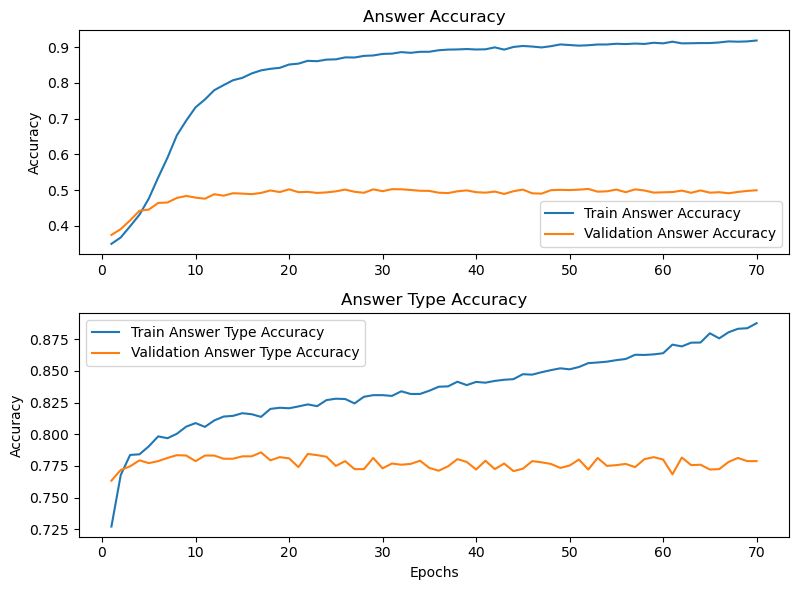

In [54]:
epochs = range(1,num_epochs+1)

# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.plot(epochs, train_accs_a, label='Train Answer Accuracy')
ax1.plot(epochs, val_accs_a, label='Validation Answer Accuracy')
ax2.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Answer Accuracy')
ax1.legend()

ax2.plot(epochs, train_accs_at, label='Train Answer Type Accuracy')
ax2.plot(epochs, val_accs_at, label='Validation Answer Type Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Answer Type Accuracy')
ax2.legend()

fig.tight_layout()

plt.show()

In [46]:
X_val = [(x1,x2) for x1,x2 in zip(X_val_1, X_val_2)]

In [49]:
val_set = DataLoader(VQADataset(X_val, y_val, ensemble=True), batch_size=32)

In [51]:
num_classes = 4
vocab_size = 4856
hidden_dim = 512
embedding_dim1 = 768*2
embedding_dim2 = 1024*2
highest_acc = -1
val_acc_a = 0
val_acc_at = 0


# Instantiate the model
model1 = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim1).to(device)
model1.load_state_dict(torch.load('/kaggle/working/model_1.pt'))
model2 = VQA_Network(num_classes, vocab_size, hidden_dim, embedding_dim2).to(device)
model2.load_state_dict(torch.load('/kaggle/working/model_2.pt'))

with torch.no_grad():
    model1.eval()
    model2.eval()
    for xs1, xs2, atypeset, answerset in val_set:
        # Move data to the device
        xs1, xs2 = xs1.to(device), xs2.to(device)
        atypeset = atypeset.to(device)
        answerset = answerset.to(device)

        # Forward pass
        answers1, atypes1 = model1(xs1)
        answers2, atypes2 = model2(xs2)
        answers = answers1+answers2
        atypes = atypes1+atypes2
        # print(xs.size())
        # print(labelset.size())
        # Compute loss
        answer_loss = criterion(answers, answerset)

        # Compute loss
        atype_loss = criterion(atypes, atypeset)

        # Update running loss
        val_running_loss_a += answer_loss.item()
        val_running_loss_at += atype_loss.item()
#             val_acc_a += calculate_acc(answers, answerset)
        val_acc_at += (torch.argmax(atypes, 1) == torch.argmax(atypeset, 1)).float().sum()
        val_acc_a += (torch.argmax(answers, 1) == torch.argmax(answerset, 1)).float().sum()

    val_acc_a = val_acc_a / len(y_val)
    val_acc_at = val_acc_at / len(y_val)
    # Calculate average loss for the epoch
    val_average_loss_a = val_running_loss_a / len(y_val)
    val_average_loss_at = val_running_loss_at / len(y_val)

    # Print progress
    print(f"Validation: Loss_a: {val_average_loss_a:.4f}, Loss_at: {val_average_loss_at:.4f}", end=' ')
    print(f"Acc_a: {val_acc_a:.4f}, Acc_at: {val_acc_at:.4f}")


Validation: Loss_a: 0.3577, Loss_at: 0.0792 Acc_a: 0.4983, Acc_at: 0.7967


In [ ]:
idx = 700

answer, atype = model(X_val[idx])
print(lb_answers.classes_[torch.argmax(answer)])
print(lb_types.classes_[torch.argmax(atype)])
print('-------------------')
print(val_df[idx])

In [ ]:
display(IM(filename='/kaggle/input/vizwiz/data/Images/'+val_df[idx][0]))

In [47]:
train_set = DataLoader(VQADataset(X, y, ensemble=True), batch_size=32)
val_set = DataLoader(VQADataset(X_val, y, ensemble=True), batch_size=32)

In [48]:
train_set = DataLoader(VQADataset(X, answerable, single=True), batch_size=32)
val_set = DataLoader(VQADataset(X_val, val_answerable, single=True), batch_size=32)

In [58]:
class VQA_Answerability(nn.Module):
    def __init__(self, embedding_dim):
        super(VQA_Answerability, self).__init__()

        self.fc = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.to(dtype=torch.float32)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [59]:
embedding_dim = 1024
train_accs = []
val_accs = []

num_epochs = 200

# Instantiate the model
model = VQA_Answerability(embedding_dim).to(device)

# Define loss function
criterion = nn.BCELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    acc = 0
    val_running_loss = 0.0
    val_acc = 0

    for xs, labelset in train_set:
        # Move data to the device
        xs = xs.to(device)
        labelset = labelset.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(xs).squeeze()
        
        # Compute loss
        loss = criterion(output, labelset)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        acc += (torch.round(output) == labelset).float().sum()

    acc = acc / len(answerable)
    # Calculate average loss for the epoch
    average_loss = running_loss / len(answerable)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}", end=' ')
    print(f"Acc: {acc:.4f}", end='\t')
    train_accs.append(acc.cpu())
    
    with torch.no_grad():
        model.eval()
        for xs, labelset in val_set:
            # Move data to the device
            xs = xs.to(device)
            labelset = labelset.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(xs).squeeze()

            # Compute loss
            loss = criterion(output, labelset)

            # Update running loss
            val_running_loss += loss.item()
            val_acc += (torch.round(output) == labelset).float().sum()

        val_acc = val_acc / len(val_answerable)
        # Calculate average loss for the epoch
        val_average_loss = val_running_loss / len(val_answerable)

        # Print progress
        print(f"Validation: Loss_at: {val_average_loss:.4f}", end=' ')
        print(f"Acc: {val_acc:.4f}")
        val_accs.append(val_acc.cpu())

# Training complete

Epoch [1/200], Loss: 0.0172 Acc: 0.7171	Validation: Loss_at: 0.0160 Acc: 0.7340
Epoch [2/200], Loss: 0.0154 Acc: 0.7519	Validation: Loss_at: 0.0150 Acc: 0.7633
Epoch [3/200], Loss: 0.0147 Acc: 0.7718	Validation: Loss_at: 0.0146 Acc: 0.7772
Epoch [4/200], Loss: 0.0144 Acc: 0.7818	Validation: Loss_at: 0.0143 Acc: 0.7835
Epoch [5/200], Loss: 0.0142 Acc: 0.7901	Validation: Loss_at: 0.0141 Acc: 0.7879
Epoch [6/200], Loss: 0.0140 Acc: 0.7953	Validation: Loss_at: 0.0140 Acc: 0.7907
Epoch [7/200], Loss: 0.0139 Acc: 0.7986	Validation: Loss_at: 0.0139 Acc: 0.7933
Epoch [8/200], Loss: 0.0138 Acc: 0.8013	Validation: Loss_at: 0.0139 Acc: 0.7958
Epoch [9/200], Loss: 0.0137 Acc: 0.8043	Validation: Loss_at: 0.0138 Acc: 0.7974
Epoch [10/200], Loss: 0.0136 Acc: 0.8063	Validation: Loss_at: 0.0138 Acc: 0.7992
Epoch [11/200], Loss: 0.0136 Acc: 0.8079	Validation: Loss_at: 0.0137 Acc: 0.7992
Epoch [12/200], Loss: 0.0135 Acc: 0.8097	Validation: Loss_at: 0.0137 Acc: 0.8008
Epoch [13/200], Loss: 0.0135 Acc: 0.8

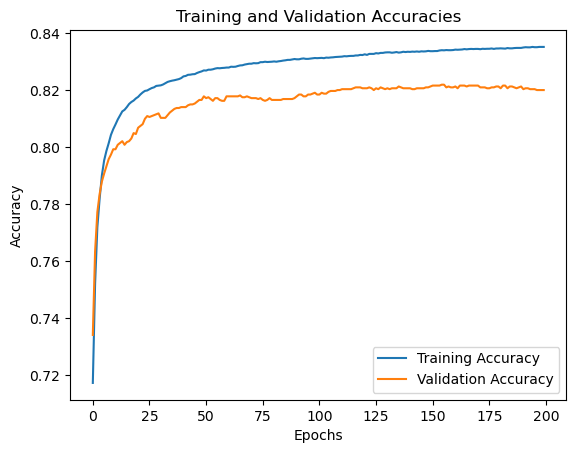

In [61]:
# Plotting the accuracies
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')

# Adding legend
plt.legend()

# Display the plot
plt.show()